In [1]:
import pandas as pd
from tqdm.auto import tqdm
import ujson
import numpy as np
from pathlib import Path
import re
import csv
import igraph as ig
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import Counter
import sys
epsilon = sys.float_info.epsilon
# https://github.com/filipinascimento/WOSRaw



In [2]:
dataName = "phst_240409_newest"
inputDataName = "phst_240409"

In [3]:
import os
os.chdir("/mnt/helios/ail/philanthrophysics/Disser")
# os.chdir("..")
print(os.getcwd())

/media/volume/sdd/ail/philanthrophysics/Disser


In [4]:
wosPath = Path("/raw/WoSTables/")
outputPath = Path("Data") # ./ = current directory
resultsPath = Path("Results") # ./ = current directory


WOSDataPath = wosPath/"WoS_2022.tsv"
WOSAbstractsPath = wosPath/"WoS_2022_abstract.tsv"

inputTableFile = outputPath/f"WoS_2022_filtered_{inputDataName}.csv"
inputTableReferencesFile = outputPath/f"WoS_2022_filtered_references_{inputDataName}.csv"

outputJustReferencesTableFile = outputPath/f"WoS_2022_filtered_JustReferences_{dataName}.csv"
outputNoveltyArticleLevelTableFile = resultsPath/f"WoS_2022_ArticleLevel_Novelty_{dataName}.csv"
outputNoveltyFieldLevelTableFile = resultsPath/f"WoS_2022_FieldLevel_Novelty_{dataName}.csv"
outputNoveltySubjectCategoriesTableFile = resultsPath/f"WoS_2022_SubjectCategories_Novelty_{dataName}.csv"

outputCitationsTableFile = outputPath/f"WoS_2022_CitationsTable_{dataName}.csv"

In [5]:
inputTableFile

PosixPath('Data/WoS_2022_filtered_phst_240409.csv')

In [6]:
# Saving philanthropy references
import pandas as pd

dfPhilanthropy = pd.read_csv(inputTableFile,low_memory=False)
# Just save the columns for UT and CI
dfPhilanthropyReferences = dfPhilanthropy[["UT","CI"]]
dfPhilanthropyReferences.to_csv(outputJustReferencesTableFile,index=False)



In [7]:
#df = pd.read_csv(outputTableFile,low_memory=False)
dfReferences = pd.read_csv(inputTableReferencesFile,low_memory=False)

In [8]:
len(dfReferences)

513406

In [9]:
len(dfPhilanthropy.drop_duplicates(subset=["UT"]))

60684

In [10]:
(dfPhilanthropy["PY"] < 1960).sum()

481

In [11]:
print("Total number of philanthropy articles:")
((dfPhilanthropy["PY"] >= 1961)*(dfPhilanthropy["PY"] <= 2017)).sum()

Total number of philanthropy articles:


41600

In [12]:
print("Total number of philanthropy articles with at least one reference:")
# CI can be like "; ; ; WOS:000528279700003; ; ;WOS:000528279700003; ; ; ; ; ; ; ; ;"
# So we need to remove the empty strings
dfPhilanthropyWithReferences = dfPhilanthropy.dropna(subset=["CI"])
citationsLists = dfPhilanthropyWithReferences["CI"].str.split(";").apply(lambda x: [y.strip() for y in x if y.strip() != ""])
citationsLists
# non empty lists mask
mask = citationsLists.apply(lambda x: len(x) > 0)
mask *= (dfPhilanthropyWithReferences["PY"] >= 1960)*(dfPhilanthropyWithReferences["PY"] <= 2017)
dfPhilanthropyWithReferences = dfPhilanthropyWithReferences[mask]
len(dfPhilanthropyWithReferences)

Total number of philanthropy articles with at least one reference:


36102

In [13]:
# total number of references
print("Total number of references:")
totalReferences = citationsLists[mask].apply(len).sum()
totalReferences

Total number of references:


778367

In [14]:
# total number of unique references
print("Total number of unique references:")
uniqueReferences = set()
for l in citationsLists[mask]:
    uniqueReferences.update(l)

print("Total unique references:",len(uniqueReferences))
# intersection with set(dfReferences["UT"])
uniqueReferences = uniqueReferences.intersection(set(dfReferences["UT"]))

print("Total unique references in WoS:",len(uniqueReferences))
len(uniqueReferences)


Total number of unique references:
Total unique references: 330118
Total unique references in WoS: 313172


313172

In [15]:
referenceUID2Index = {UID:index for index,UID in enumerate(dfReferences["UT"])}

In [16]:
dfReferences.sort_values(by=["PY"],inplace=True,ascending=True)

In [17]:
Counter(dfPhilanthropy["SO"].dropna()).most_common(20)

[('NONPROFIT AND VOLUNTARY SECTOR QUARTERLY', 1431),
 ('VOLUNTAS', 984),
 ('SUSTAINABILITY', 386),
 ('JOURNAL OF ECONOMIC BEHAVIOR & ORGANIZATION', 378),
 ('FRONTIERS IN PSYCHOLOGY', 376),
 ('NONPROFIT MANAGEMENT & LEADERSHIP', 372),
 ('JOURNAL OF BUSINESS ETHICS', 370),
 ('JOURNAL OF PUBLIC ECONOMICS', 359),
 ('PLOS ONE', 264),
 ('SOCIAL ENTERPRISE JOURNAL', 221),
 ('ECONOMICS LETTERS', 220),
 ('PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA',
  207),
 ('JOURNAL OF PERSONALITY AND SOCIAL PSYCHOLOGY', 202),
 ('JOURNAL OF THEORETICAL BIOLOGY', 200),
 ('PROCEEDINGS OF THE ROYAL SOCIETY B-BIOLOGICAL SCIENCES', 195),
 ('FOUNDATION REVIEW', 185),
 ('SOCIAL MOVEMENT STUDIES', 173),
 ('JOURNAL OF TAXATION', 164),
 ('JOURNAL OF NONPROFIT EDUCATION AND LEADERSHIP', 160),
 ('PERSONALITY AND INDIVIDUAL DIFFERENCES', 157)]

In [18]:
# subjectCategoriesSet = set([subjectCategory for subjectCategories in dfReferences["WC"].to_list() for subjectCategory in str(subjectCategories).lower().split(": ")])
# if "nan" in subjectCategoriesSet:
#     subjectCategoriesSet.remove("nan")

# index2SubjectCategory = {index:subjectCategory for index,subjectCategory in enumerate(subjectCategoriesSet)}
# subjectCategory2Index = {subjectCategory:index for index,subjectCategory in enumerate(subjectCategoriesSet)}





In [19]:
# Articles without WC (percentage)
dfReferencesFiltered = dfReferences.dropna(subset="WC")
originalCount = len(dfReferences)
filteredCount = len(dfReferencesFiltered)
print(originalCount-filteredCount,(originalCount-filteredCount)/filteredCount*100.0,"%")



55 0.010713916988571173 %


In [20]:
# Maximum number of WC in a single article
lengths = dfReferencesFiltered["WC"].str.split(";").apply(len)
max_length = lengths.max()
print(max_length)

9


In [21]:
# Measure
referencePaperUIDs2SubjectCategories = {}
referencePaperUIDs2Year = {}
for referenceUID,subjectCategories,year in zip(tqdm(dfReferences["UT"]),dfReferences["WC"],dfReferences["PY"]):
    if(subjectCategories == subjectCategories):
        subjectCategories = subjectCategories.lower().split("; ")
        referencePaperUIDs2SubjectCategories[referenceUID] = subjectCategories
    referencePaperUIDs2Year[referenceUID] = year


  0%|          | 0/513406 [00:00<?, ?it/s]

In [22]:
# Calculate the number of unique references between 1960 and 2017
startYear = 1960
endYear = 2017
uniqueReferencesInTimePeriod = set()
maxSubjectCategoriesPerPaperInTimePeriod = 0
allReferencesFromData =  set(dfReferences["UT"])

paperUIDsCiting = []
paperUIDsCited = []
paperYearsCiting = []
paperYearsCited = []
paperYearsCitedSubjectCategories = []
for philanthropyUID,referencesList,year in zip(tqdm(dfPhilanthropy["UT"]),dfPhilanthropy["CI"],dfPhilanthropy["PY"]):
    if referencesList==referencesList:
        for referenceUID in referencesList.split("; "):
            if referenceUID and referenceUID and referenceUID in allReferencesFromData:
                if referenceUID in referencePaperUIDs2SubjectCategories:
                    referenceSubjectCategory = referencePaperUIDs2SubjectCategories[referenceUID]
                else:
                    referenceSubjectCategory = []
                if(year>=startYear and year<=endYear):
                    uniqueReferencesInTimePeriod.add(referenceUID)
                    maxSubjectCategoriesPerPaperInTimePeriod = max(maxSubjectCategoriesPerPaperInTimePeriod,len(referenceSubjectCategory))
                referenceSubjectCategory = ";".join(referenceSubjectCategory)
                paperUIDsCiting.append(philanthropyUID)
                paperUIDsCited.append(referenceUID)
                paperYearsCiting.append(year)
                paperYearsCited.append(referencePaperUIDs2Year[referenceUID])
                paperYearsCitedSubjectCategories.append(referenceSubjectCategory)
                
                
print(f"Unique references in time period {startYear}-{endYear}: {len(uniqueReferencesInTimePeriod)}")
print(f"Max subject categories per paper in time period {startYear}-{endYear}: {maxSubjectCategoriesPerPaperInTimePeriod}")

# save file
dfCitationsTable = pd.DataFrame({"CitingUID":paperUIDsCiting,"CitedUID":paperUIDsCited,"CitingYear":paperYearsCiting,"CitedYear":paperYearsCited,"CitedSubjectCategories":paperYearsCitedSubjectCategories})
dfCitationsTable.to_csv(outputCitationsTableFile,index=False)

  0%|          | 0/60685 [00:00<?, ?it/s]

Unique references in time period 1960-2017: 313172
Max subject categories per paper in time period 1960-2017: 9


In [23]:
# Note: Maybe use fractional counting of the subject categories in future???
# Getting subject categories of the references of each paper
paperUID2ReferencesSubjectCategories = {}
for philanthropyUID,referencesList in zip(tqdm(dfPhilanthropy["UT"]),dfPhilanthropy["CI"]):
    if referencesList==referencesList:
        for referenceUID in referencesList.split("; "):
            if referenceUID and referenceUID and referenceUID in referencePaperUIDs2SubjectCategories:
                if philanthropyUID not in paperUID2ReferencesSubjectCategories:
                    paperUID2ReferencesSubjectCategories[philanthropyUID] = set()
                paperUID2ReferencesSubjectCategories[philanthropyUID].update(referencePaperUIDs2SubjectCategories[referenceUID])

subjectCategoryReference2PaperUID = {}
for philanthropyUID,subjectCategories in tqdm(paperUID2ReferencesSubjectCategories.items()):
    for subjectCategory in subjectCategories:
        if subjectCategory not in subjectCategoryReference2PaperUID:
            subjectCategoryReference2PaperUID[subjectCategory] = set()
        subjectCategoryReference2PaperUID[subjectCategory].add(philanthropyUID)


  0%|          | 0/60685 [00:00<?, ?it/s]

  0%|          | 0/53632 [00:00<?, ?it/s]

In [24]:
year2paperUIDs = {}
for year,philanthropyUID in zip(tqdm(dfPhilanthropy["PY"]),dfPhilanthropy["UT"]):
    if year not in year2paperUIDs:
        year2paperUIDs[year] = set()
    year2paperUIDs[year].add(philanthropyUID)

paperUID2Year = {uid:year for uid,year in zip(dfPhilanthropy["UT"],dfPhilanthropy["PY"])}


  0%|          | 0/60685 [00:00<?, ?it/s]

In [25]:
startingYear = 1960
coreSubjectCategories = set()
allYears = sorted(list(year2paperUIDs.keys()))
coreYearRange = range(allYears[0],startingYear)
pioneerNoveltyYears = range(startingYear,allYears[-1]+1)
fullYearRange = range(allYears[0],allYears[-1]+1)

subjectCategory2IntroductionYear = {}
year2IntroducedSubjectCategories = {}
# core period
for year in tqdm(coreYearRange):
    if year in year2paperUIDs:
        for philanthropyUID in year2paperUIDs[year]:
            if philanthropyUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[philanthropyUID]
                for subjectCategory in subjectCategories:                    
                    if subjectCategory not in coreSubjectCategories:
                        coreSubjectCategories.add(subjectCategory)
                    coreSubjectCategories.add(subjectCategory)

alreadyIntroducedSubjectCategories = coreSubjectCategories.copy()
# non-core period
for year in tqdm(pioneerNoveltyYears):
    if year in year2paperUIDs:
        for philanthropyUID in year2paperUIDs[year]:
            if philanthropyUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[philanthropyUID]
                for subjectCategory in subjectCategories:
                    if(subjectCategory not in alreadyIntroducedSubjectCategories):
                        if subjectCategory not in subjectCategory2IntroductionYear:
                            subjectCategory2IntroductionYear[subjectCategory] = year
                        if year not in year2IntroducedSubjectCategories:
                            year2IntroducedSubjectCategories[year] = set()
                        year2IntroducedSubjectCategories[year].add(subjectCategory)
                        alreadyIntroducedSubjectCategories.add(subjectCategory)

print("Core Set: ")
print(coreSubjectCategories)


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Core Set: 
{'business, finance', 'medicine, general & internal', 'psychology, developmental', 'mathematics', 'philosophy', 'anthropology', 'psychology, mathematical', 'psychology, educational', 'history', 'statistics & probability', 'sociology', 'social issues', 'psychology', 'zoology', 'psychology, applied', 'behavioral sciences', 'education & educational research', 'social sciences, mathematical methods', 'management', 'economics', 'multidisciplinary sciences', 'psychology, multidisciplinary', 'social sciences, interdisciplinary', 'psychology, social', 'ethics', 'industrial relations & labor', 'political science', 'biology', 'law', 'mathematics, interdisciplinary applications'}


In [26]:
inspectCoreSubjectCategory = "mineralogy"
# in the core period and UT in subjectCategoryReference2PaperUID[inspectCoreSubjectCategory]
dfPhilanthropy[(dfPhilanthropy["PY"]<startingYear)*(dfPhilanthropy["UT"].isin(subjectCategoryReference2PaperUID[inspectCoreSubjectCategory]))]


,PT,AU,BE,AF,TI,SO,SE,LA,DT,CT,...,DI,EA,EB,PG,WC,WE,SC,PM,OA,UT


In [27]:
len(coreSubjectCategories)

30

In [28]:
## what is this used for?
# dfPhilanthropy.drop["PioneerNoveltyScore"]

In [29]:
paperUID2PioneerNoveltyScore = {} # Number of new Subject categories introduced by that paper
paperUIDIntroducedSubjectCategories = {} # which subject categories were introduced by the paper
beforeYearSubjectCategories = coreSubjectCategories.copy()
year2PioneerNoveltyScore = {} 
for year in tqdm(pioneerNoveltyYears):
    for paperUID in year2paperUIDs[year]:
        if paperUID in paperUID2ReferencesSubjectCategories:
            subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
            introducedSubjectCategories = subjectCategories - beforeYearSubjectCategories
            paperUIDIntroducedSubjectCategories[paperUID] = introducedSubjectCategories
            paperUID2PioneerNoveltyScore[paperUID] = len(introducedSubjectCategories)
    if year in year2IntroducedSubjectCategories:
        year2PioneerNoveltyScore[year] = len(year2IntroducedSubjectCategories[year])
        beforeYearSubjectCategories.update(year2IntroducedSubjectCategories[year])


  0%|          | 0/63 [00:00<?, ?it/s]

In [30]:
dfPhilanthropy["PioneerNoveltyScore"] = dfPhilanthropy["UT"].map(paperUID2PioneerNoveltyScore)
dfPhilanthropy["IntroducedSubjectCategories"] = dfPhilanthropy["UT"].map(paperUIDIntroducedSubjectCategories)
dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)
# Save yearly scores (fieldlevel)
dfYearlyData = pd.DataFrame()
# fullYearRange
dfYearlyData["Year"] = fullYearRange
# include number of papers each year
dfYearlyData["PaperCount"] = [len(year2paperUIDs[year]) if year in year2paperUIDs else 0 for year in fullYearRange]
# include number of introduced subject categories each year
dfYearlyData["IntroducedSubjectCategories"] = [list(year2IntroducedSubjectCategories[year]) if year in year2IntroducedSubjectCategories else [] for year in fullYearRange]
# Pioneer Novelty Score
dfYearlyData["PioneerNoveltyScore"] = [year2PioneerNoveltyScore[year] if year in year2PioneerNoveltyScore else 0 for year in fullYearRange]
# Note: Maybe add other properties?
dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)


In [31]:
year2IntroducedSubjectCategories


{1961: {'business',
  'clinical neurology',
  'family studies',
  'psychiatry',
  'social work'},
 1962: {'area studies'},
 1963: {'psychology, biological'},
 1965: {'psychology, clinical'},
 1966: {'nursing', 'psychology, experimental'},
 1967: {'development studies',
  'psychology, psychoanalysis',
  'public administration'},
 1968: {'communication',
  'humanities, multidisciplinary',
  'mathematical & computational biology',
  'nutrition & dietetics',
  'pediatrics',
  'physiology',
  'substance abuse'},
 1969: {'public, environmental & occupational health'},
 1970: {'demography',
  'ecology',
  'ethnic studies',
  'evolutionary biology',
  'soil science',
  'water resources'},
 1971: {'biochemistry & molecular biology',
  'biophysics',
  'cardiac & cardiovascular systems',
  'cell biology',
  'education, special',
  'genetics & heredity',
  'health care sciences & services',
  'health policy & services',
  'history of social sciences',
  'international relations',
  'language & lin

In [32]:
investigateYear = 2015
investigateAllArticles = False # if False, only articles from investigateYear are shown

print(year2IntroducedSubjectCategories[investigateYear])
for subjectCategory in year2IntroducedSubjectCategories[investigateYear]:
    articles = dfPhilanthropy[dfPhilanthropy["UT"].isin(subjectCategoryReference2PaperUID[subjectCategory])]
    if(not investigateAllArticles):
        articles = articles[articles["PY"]==investigateYear]
        print("Articles introducing "+subjectCategory+" ("+str(investigateYear)+"):")
    else:
        print("Articles of "+subjectCategory+":")
    display(articles)


{'materials science, characterization & testing'}
Articles introducing materials science, characterization & testing (2015):


,PT,AU,BE,AF,TI,SO,SE,LA,DT,CT,...,EB,PG,WC,WE,SC,PM,OA,UT,PioneerNoveltyScore,IntroducedSubjectCategories
33394,Journal,"Marcan, Peter; Rofar, Jan; Micieta, Branislav",NaN,"Marcan, Peter; Rofar, Jan; Micieta, Branislav",Implementation of Robots Cooperating with Huma...,INTERNATIONAL JOURNAL OF ENGINEERING RESEARCH ...,NaN,English,Article,NaN,...,NaN,8,"Engineering, Multidisciplinary",WOS.ESCI,Engineering,NaN,NaN,WOS:000219520600003,1.0,"{materials science, characterization & testing}"


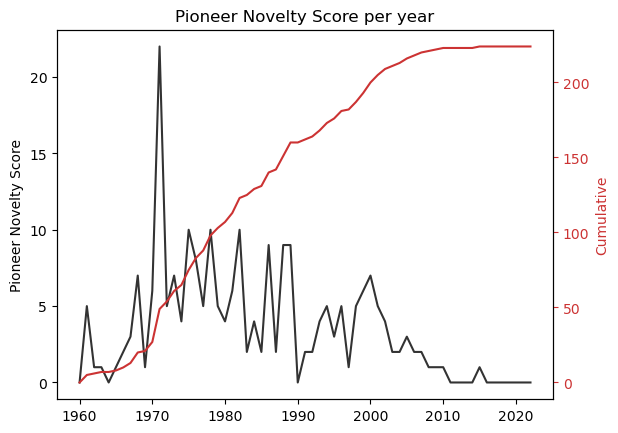

In [33]:
# Plot the pioneer novelty score per year and cumulative
plotRange = (1960,2022)
plt.figure()
# y = pioneerNoveltyYears
# x = year2PioneerNoveltyScore, 0 when not available
# limit to the plot range
y = list(pioneerNoveltyYears)
y = [year for year in y if year>=plotRange[0] and year<=plotRange[1]]
x = [year2PioneerNoveltyScore[year] if year in year2PioneerNoveltyScore else 0 for year in y]
# limit years to the plot range

plt.plot(y,x,label="Value",color="#333333")
plt.ylabel("Pioneer Novelty Score")
plt.twinx()
# plt.plot(list(year2PioneerNoveltyScore.keys()),np.cumsum(list(year2PioneerNoveltyScore.values())),label="Value",color="#CC3333")
plt.plot(y,np.cumsum(x),label="Cumulative",color="#CC3333")
plt.xlabel("Year")
plt.ylabel("Cumulative")
# set color of the label and tick labels
plt.gca().yaxis.label.set_color("#CC3333")
plt.gca().tick_params(axis='y', colors="#CC3333")
plt.title("Pioneer Novelty Score per year")
plt.show()


#-------------------------------

In [34]:
pioneerNoveltyImpactTimeWindows = [5,10]
# Article A -> {SC1,SC2,...}
# SC1 -> PapersReferencing(timewindow,SC1)/TotalPublications(timeWindow)
# SC2 -> PapersReferencing(timewindow,SC2)/TotalPublications(timeWindow)
# ...
# Article-level Pioneer Novelty Impact = max(SC1,SC2,...)
# timewindow is defined as the time window after the introduction of the subject category

subjectCategory2NoveltyImpactByWindow = {}
for pioneerNoveltyImpactTimeWindow in pioneerNoveltyImpactTimeWindows:
    subjectCategory2NoveltyImpact = {} # PapersReferencing(timewindow,SC1)/TotalPublications(timeWindow)
    for subjectCategory,introducingYear in subjectCategory2IntroductionYear.items():
        windowYearRange = range(introducingYear+1,introducingYear+pioneerNoveltyImpactTimeWindow+1)
        totalPaperCount = 0
        for year in windowYearRange:
            if year in year2paperUIDs:
                totalPaperCount+=len(year2paperUIDs[year])
        allPapersReferencing = subjectCategoryReference2PaperUID[subjectCategory]
        windowPapersReferencing = set()
        for paperUID in allPapersReferencing:
            if paperUID2Year[paperUID] in windowYearRange:
                windowPapersReferencing.add(paperUID)
        subjectCategory2NoveltyImpact[subjectCategory] = len(windowPapersReferencing)/totalPaperCount
    subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] = subjectCategory2NoveltyImpact


In [35]:
# PIONEER/PERIPHERY NOVELTY IMPACT of subject categories
dfSubjectCategoryData = pd.DataFrame()
# add all subject categories, including core
dfSubjectCategoryData["SubjectCategory"] = list(coreSubjectCategories.union(set(subjectCategory2IntroductionYear.keys())))
# Set property Baseline to 1 for core subject categories
isBaseline = [subjectCategory in coreSubjectCategories for subjectCategory in dfSubjectCategoryData["SubjectCategory"]]
dfSubjectCategoryData["Baseline"] = isBaseline
# Set property IntroductionYear not all subject categories have an introduction year
dfSubjectCategoryData["IntroductionYear"] = [subjectCategory2IntroductionYear[subjectCategory] if subjectCategory in subjectCategory2IntroductionYear else np.NaN for subjectCategory in dfSubjectCategoryData["SubjectCategory"]]
# Set property NoveltyImpact
for pioneerNoveltyImpactTimeWindow in pioneerNoveltyImpactTimeWindows:
    dfSubjectCategoryData["NoveltyImpact_W"+str(pioneerNoveltyImpactTimeWindow)] = [subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][subjectCategory] if subjectCategory in subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] else np.NaN for subjectCategory in dfSubjectCategoryData["SubjectCategory"]]

# order by year
dfSubjectCategoryData["IntroductionYear"] = dfSubjectCategoryData["IntroductionYear"].fillna(-1)
dfSubjectCategoryData.sort_values(by=["IntroductionYear"],inplace=True,ascending=True)
# set back nan values
dfSubjectCategoryData["IntroductionYear"] = dfSubjectCategoryData["IntroductionYear"].replace(-1,np.NaN)
# reset index
dfSubjectCategoryData.reset_index(drop=True,inplace=True)

# Save to file
dfSubjectCategoryData.to_csv(outputNoveltySubjectCategoriesTableFile,index=False)


In [36]:
dfSubjectCategoryData
# Subject category-level pioneer novelty impact
# Table with pioneer novelty impact for each subject category and introduction year
# baseline means that it is from the core set of subject categories

,SubjectCategory,Baseline,IntroductionYear,NoveltyImpact_W5,NoveltyImpact_W10
0,"business, finance",True,NaN,NaN,NaN
1,mathematics,True,NaN,NaN,NaN
2,"psychology, developmental",True,NaN,NaN,NaN
3,"psychology, social",True,NaN,NaN,NaN
4,social issues,True,NaN,NaN,NaN
...,...,...,...,...,...
249,quantum science & technology,False,2007.0,0.000183,0.000069
250,mineralogy,False,2008.0,0.000318,0.000158
251,"literature, african, australian, canadian",False,2009.0,0.000358,0.000380
252,"materials science, ceramics",False,2010.0,0.000130,0.000190


In [37]:
# Article A -> {SC1,SC2,...}
# SC1 -> PapersReferencing(timewindow,SC1)/TotalPublications(timeWindow)
# SC2 -> PapersReferencing(timewindow,SC2)/TotalPublications(timeWindow)
# ...
# Article-level Pioneer Novelty Impact = max(SC1,SC2,...)
# timewindow is defined as the time window after the introduction of the subject category

paperUID2PioneerNoveltyImpactByWindow = {}
paperUID2PioneerNoveltyImpactScoresByWindow = {}
for pioneerNoveltyImpactTimeWindow in pioneerNoveltyImpactTimeWindows:
    paperUID2PioneerNoveltyImpact = {}
    paperUID2PioneerNoveltyImpactScores = {}
    for paperUID in dfPhilanthropy["UT"]:
        if paperUID in paperUIDIntroducedSubjectCategories:
            introducedSubjectCategories = paperUIDIntroducedSubjectCategories[paperUID]
            impactScores = []
            for subjectCategory in introducedSubjectCategories:
                if subjectCategory in subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow]:
                    impactScores.append(subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][subjectCategory])
            if(len(impactScores)):
                maxImpact = np.nanmax(impactScores)
            else:
                maxImpact = np.NaN
            paperUID2PioneerNoveltyImpact[paperUID] = maxImpact
            paperUID2PioneerNoveltyImpactScores[paperUID] = impactScores
    paperUID2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] = paperUID2PioneerNoveltyImpact
    paperUID2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow] = paperUID2PioneerNoveltyImpactScores


In [38]:
# adding to our table
for pioneerNoveltyImpactTimeWindow in pioneerNoveltyImpactTimeWindows:
    dfPhilanthropy["PioneerNoveltyImpact_W"+str(pioneerNoveltyImpactTimeWindow)] = dfPhilanthropy["UT"].map(paperUID2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow])
    dfPhilanthropy["PioneerNoveltyImpactScores_W"+str(pioneerNoveltyImpactTimeWindow)] = dfPhilanthropy["UT"].map(paperUID2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow])

# Save to file
dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)



In [39]:
year2PioneerNoveltyImpactScoresByWindow = {}
year2PioneerNoveltyImpactByWindow  = {}
for pioneerNoveltyImpactTimeWindow in pioneerNoveltyImpactTimeWindows:
    year2PioneerNoveltyImpactScores = {}
    year2PioneerNoveltyImpact = {}
    for year in pioneerNoveltyYears:
        impactScores = []
        if(year in year2IntroducedSubjectCategories):
            introducedSubjectCategoriesInYear = year2IntroducedSubjectCategories[year]

            for subjectCategory in introducedSubjectCategoriesInYear:
                if subjectCategory in subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow]:
                    impactScores.append(subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][subjectCategory])
        if(len(impactScores)):
            maxImpact = np.nanmax(impactScores)
        else:
            maxImpact = np.NaN
        year2PioneerNoveltyImpact[year] = maxImpact
        year2PioneerNoveltyImpactScores[year] = impactScores
    year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow] = year2PioneerNoveltyImpactScores
    year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] = year2PioneerNoveltyImpact


In [40]:

for pioneerNoveltyImpactTimeWindow in pioneerNoveltyImpactTimeWindows:
    dfYearlyData["PioneerNoveltyImpact_W"+str(pioneerNoveltyImpactTimeWindow)] = [year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][year] if year in year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] else np.NaN for year in fullYearRange]
    dfYearlyData["PioneerNoveltyImpactScores_W"+str(pioneerNoveltyImpactTimeWindow)] = [year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow][year] if year in year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow] else [] for year in fullYearRange]

# Save to file
dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)


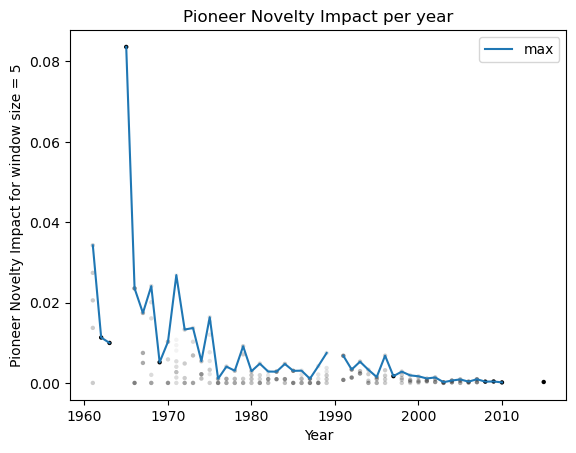

In [41]:
pioneerNoveltyImpactTimeWindow = 5
plt.figure()
plotRange = (1960,2017)
y = list(pioneerNoveltyYears)
y = [year for year in y if year>=plotRange[0] and year<=plotRange[1]]
x = [year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][year] if year in year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] else 0 for year in y]
plt.plot(y,x,label="max")
# also plot the impact scores of each year as scatter as individual points
if pioneerNoveltyImpactTimeWindow==pioneerNoveltyImpactTimeWindows[0]:
    for year in y:
        if year in year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow]:
            scores = year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow][year]
            if(len(scores)):
                plt.scatter([year]*len(scores), scores, color="black", s=10, alpha=1/len(scores), edgecolors='none')


plt.ylabel("Pioneer Novelty Impact for window size = "+str(pioneerNoveltyImpactTimeWindow))
plt.xlabel("Year")
plt.title("Pioneer Novelty Impact per year")
plt.legend()
plt.show()


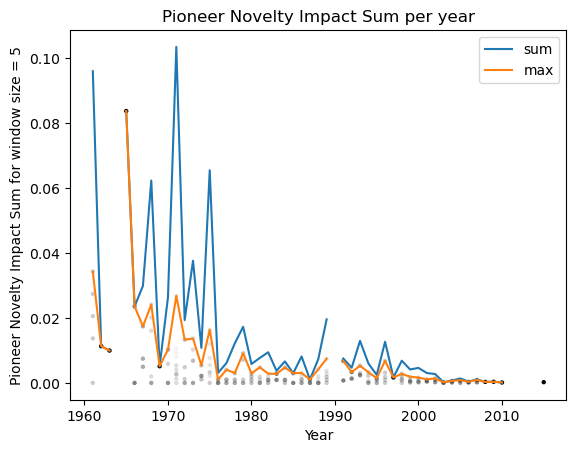

In [42]:
pioneerNoveltyImpactTimeWindow = 5
year2PioneerNoveltyImpactsSum = {}
for year in pioneerNoveltyYears:
    if year in year2IntroducedSubjectCategories:
        introducedSubjectCategoriesInYear = year2IntroducedSubjectCategories[year]
        year2PioneerNoveltyImpactsSum[year] = np.nansum([subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][subjectCategory] for subjectCategory in introducedSubjectCategoriesInYear if subjectCategory in subjectCategory2NoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow]])
    else:
        year2PioneerNoveltyImpactsSum[year] = np.NaN

plt.figure()
y = list(pioneerNoveltyYears)
x = [year2PioneerNoveltyImpactsSum[year] if year in year2PioneerNoveltyImpactsSum else 0 for year in y]
plt.plot(y,x,label="sum")
x = [year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][year] if year in year2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow] else 0 for year in y]
plt.plot(y,x,label="max")
# also plot the impact scores of each year as scatter as individual points
if pioneerNoveltyImpactTimeWindow==pioneerNoveltyImpactTimeWindows[0]:
    for year in y:
        if year in year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow]:
            scores = year2PioneerNoveltyImpactScoresByWindow[pioneerNoveltyImpactTimeWindow][year]
            if(len(scores)):
                plt.scatter([year]*len(scores), scores, color="black", s=10, alpha=1/len(scores), edgecolors='none')

plt.ylabel("Pioneer Novelty Impact Sum for window size = "+str(pioneerNoveltyImpactTimeWindow))
plt.xlabel("Year")
plt.title("Pioneer Novelty Impact Sum per year")
plt.legend()
plt.show()


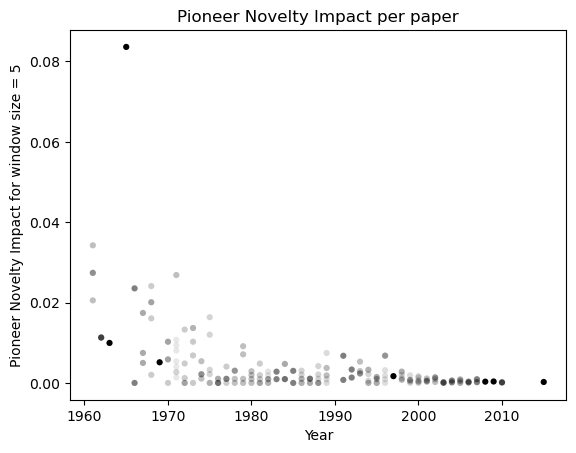

In [43]:
# Paper-level should be the same as field level (NO NEED TO PLOT THIS)
pioneerNoveltyImpactTimeWindow = 5
plt.figure()
# only papers with a valid score vs year
for year,papersUIDs in year2paperUIDs.items():
    validScores = [paperUID2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow][paperUID] for paperUID in papersUIDs if paperUID in paperUID2PioneerNoveltyImpactByWindow[pioneerNoveltyImpactTimeWindow]]
    # remove nans
    validScores = [score for score in validScores if score==score]
    if(len(validScores)):
        plt.scatter([year]*len(validScores), validScores, color="black", s=20, alpha=1/len(validScores), edgecolors='none')
plt.ylabel("Pioneer Novelty Impact for window size = "+str(pioneerNoveltyImpactTimeWindow))
plt.xlabel("Year")
plt.title("Pioneer Novelty Impact per paper")
plt.show()



In [44]:
################################################ 
# Shortener Novelty
################################################ 


subjectCategoriesSet = set([subjectCategory for subjectCategories in dfReferencesFiltered["WC"].to_list() for subjectCategory in str(subjectCategories).lower().split("; ")])
if "nan" in subjectCategoriesSet:
    subjectCategoriesSet.remove("nan")

index2SubjectCategory = {index:subjectCategory for index,subjectCategory in enumerate(subjectCategoriesSet)}
subjectCategory2Index = {subjectCategory:index for index,subjectCategory in enumerate(subjectCategoriesSet)}



#  
previousNetwork = ig.Graph(len(subjectCategory2Index),directed=False)

scYearlyNetworks = {}
paper2ShortenerNoveltyAverage = {}
paper2ShortenerNoveltyMedian = {}
paper2ShortenerNoveltyMax = {}

year2ShortenerNoveltyAverage = {}
year2ShortenerNoveltyMedian = {}
year2ShortenerNoveltyMax = {}

paper2ShortenerSubjectCategories = {}

# add edges to the graph based on the SC pairs in the references
yearRange = range(min(year2paperUIDs.keys()),max(year2paperUIDs.keys())+1)
for year in tqdm(yearRange):
    newNetwork = previousNetwork.copy()
    previousNetwork = previousNetwork.simplify(combine_edges={"weight":"sum"})
    allYearEdge2NoveltyComponent = {}
    distancesBuffer = {}
    edgesAndWeights = Counter()
    if(year in year2paperUIDs):
        papers = year2paperUIDs[year]
        for paperUID in papers:
            if paperUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
                subjectCategories = [subjectCategory2Index[subjectCategory] for subjectCategory in subjectCategories]
                subjectCategories = list(set(subjectCategories))
                edges = list(combinations(subjectCategories,2))
                # make edges min(),max()
                edges = [(min(edge),max(edge)) for edge in edges]
                edgesSet = set(edges)
                edgesAndWeights.update(edgesSet)
                # previous distances between all new edges
                noveltyComponents = []
                for edge in edgesSet:
                    if(edge in distancesBuffer):
                        distance = distancesBuffer[edge]
                    else:
                        distance = previousNetwork.distances(source=edge[0],target=edge[1])[0][0]
                        distancesBuffer[edge] = distance
                    if(1.0-1.0/distance>epsilon): # check FIX #if(1-1.0/distance>0):
                        noveltyComponents.append(1-1.0/distance)
                        allYearEdge2NoveltyComponent[edge] = 1-1.0/distance
                        if(paperUID not in paper2ShortenerSubjectCategories):
                            paper2ShortenerSubjectCategories[paperUID] = []
                        paper2ShortenerSubjectCategories[paperUID].append((edge[0],edge[1],1-1.0/distance))

                if(noveltyComponents):
                    paper2ShortenerNoveltyAverage[paperUID] = np.average(noveltyComponents)
                    paper2ShortenerNoveltyMedian[paperUID] = np.median(noveltyComponents)
                    paper2ShortenerNoveltyMax[paperUID] = np.max(noveltyComponents)
                else:
                    paper2ShortenerNoveltyAverage[paperUID] = 0
                    paper2ShortenerNoveltyMedian[paperUID] = 0
                    paper2ShortenerNoveltyMax[paperUID] = 0
    noveltyYearlyComponents = []
    for edge in edgesAndWeights.keys():
        if(edge in distancesBuffer):
            distance = distancesBuffer[edge]
        else:
            distance = previousNetwork.distances(source=edge[0],target=edge[1])[0][0]
            distancesBuffer[edge] = distance
        if(1.0-1.0/distance>epsilon):
            noveltyYearlyComponents.append(1-1.0/distance)
            allYearEdge2NoveltyComponent[edge] = 1-1.0/distance
    if(noveltyYearlyComponents):
        year2ShortenerNoveltyAverage[year] = np.average(noveltyYearlyComponents)
        year2ShortenerNoveltyMedian[year] = np.median(noveltyYearlyComponents)
        year2ShortenerNoveltyMax[year] = np.max(noveltyYearlyComponents)
    else:
        year2ShortenerNoveltyAverage[year] = 0
        year2ShortenerNoveltyMedian[year] = 0
        year2ShortenerNoveltyMax[year] = 0
    
    allYearEdges = list(edgesAndWeights.keys())
    allYearWeights = [edgesAndWeights[edge] for edge in allYearEdges]
    newNetwork.add_edges(allYearEdges,attributes={"weight":allYearWeights})
    previousNetwork = newNetwork
    scYearlyNetworks[year] = newNetwork




  0%|          | 0/124 [00:00<?, ?it/s]

In [45]:
# For each element in paper2ShortenerSubjectCategories we need to make the edges converted back to subject categories

paper2ShortenerSubjectCategoriesConverted = {}
for paperUID,edges in paper2ShortenerSubjectCategories.items():
    paper2ShortenerSubjectCategoriesConverted[paperUID] = [(index2SubjectCategory[edge[0]],index2SubjectCategory[edge[1]],edge[2]) for edge in edges]

In [46]:
dfPhilanthropy["ShortenerNoveltyScoreAvg"] = [paper2ShortenerNoveltyAverage[entry] if entry in paper2ShortenerNoveltyAverage else 0.0 for entry in dfPhilanthropy["UT"]]
dfPhilanthropy["ShortenerNoveltyScoreMedian"] = [paper2ShortenerNoveltyMedian[entry] if entry in paper2ShortenerNoveltyMedian else 0.0 for entry in dfPhilanthropy["UT"]]
dfPhilanthropy["ShortenerNoveltyScoreMax"] = [paper2ShortenerNoveltyMax[entry] if entry in paper2ShortenerNoveltyMax else 0.0 for entry in dfPhilanthropy["UT"]]
# paper2ShortenerSubjectCategoriesConverted
dfPhilanthropy["ShortenerNoveltySubjectCategories"] = dfPhilanthropy["UT"].map(paper2ShortenerSubjectCategoriesConverted)
dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)


In [47]:
dfYearlyData["ShortenerNoveltyScoreAvg"] = [year2ShortenerNoveltyAverage[year] if year in year2ShortenerNoveltyAverage else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyScoreMedian"] = [year2ShortenerNoveltyMedian[year] if year in year2ShortenerNoveltyMedian else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyScoreMax"] = [year2ShortenerNoveltyMax[year] if year in year2ShortenerNoveltyMax else 0.0 for year in dfYearlyData["Year"]]

dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)


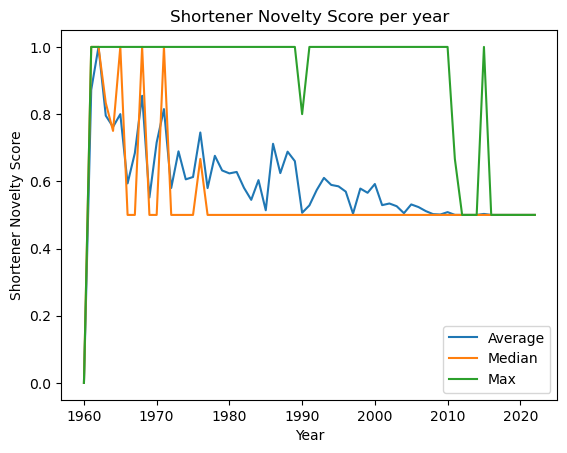

In [48]:
plotRange = (1960,2022)
dfYearlyDataPlot = dfYearlyData[(dfYearlyData["Year"]>=plotRange[0]) & (dfYearlyData["Year"]<=plotRange[1])]
plt.figure()
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyScoreAvg"],label="Average")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyScoreMedian"],label="Median")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyScoreMax"],label="Max")
plt.xlabel("Year")
plt.ylabel("Shortener Novelty Score")
plt.title("Shortener Novelty Score per year")
plt.legend()
plt.savefig("ShortenerNoveltyScorePerYear2.png",dpi=300,bbox_inches='tight')
plt.show()



In [50]:
# citations received for each pair of subject category over the years
citationsReceivedSCPairYear = {}
citationsReceivedSCYear = {}
citationsReceivedSCPairYearNonNormalized = {}
citationsReceivedSCYearNonNormalized = {}
totalPublicationsPerYear = {}
cumulativeCitationsReceivedSCYear = {}
allTimePublications = 0

# add edges to the graph based on the SC pairs in the references
yearRange = range(min(year2paperUIDs.keys()),max(year2paperUIDs.keys())+1)
cummulativeNodesAndWeights = Counter()
for year in tqdm(yearRange):
    edgesAndWeights = Counter()
    nodesAndWeights = Counter()
    if(year in year2paperUIDs):
        papers = year2paperUIDs[year]
        for paperUID in papers:
            if paperUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
                subjectCategories = [subjectCategory2Index[subjectCategory] for subjectCategory in subjectCategories]
                subjectCategories = list(set(subjectCategories))
                edges = list(combinations(subjectCategories,2))
                # make edges min(),max()
                edges = [(min(edge),max(edge)) for edge in edges]
                edgesAndWeights.update(set(edges))
                nodesAndWeights.update(set(subjectCategories))
    # adjust the weights by the number of publications on that year i.e., / total publications
    totalPublications = len(papers)
    totalPublicationsPerYear[year] = totalPublications
    allTimePublications+=totalPublications
    cummulativeNodesAndWeights.update(nodesAndWeights)
    edgesAndCounts = edgesAndWeights.copy()
    nodesAndCounts = nodesAndWeights.copy()
    
    if(totalPublications):
        for edge,weight in edgesAndWeights.items():
            edgesAndWeights[edge] = weight/totalPublications
        for node,weight in nodesAndWeights.items():
            nodesAndWeights[node] = weight/totalPublications
        
    citationsReceivedSCPairYear[year] = edgesAndWeights
    citationsReceivedSCYear[year] = nodesAndWeights
    
    citationsReceivedSCPairYearNonNormalized[year] = edgesAndCounts
    citationsReceivedSCYearNonNormalized[year] = nodesAndCounts
    

    cumulativeCitationsReceivedSCYear[year] = cummulativeNodesAndWeights.copy()
    for node,weight in cumulativeCitationsReceivedSCYear[year].items():
        cumulativeCitationsReceivedSCYear[year][node] = weight/allTimePublications



  0%|          | 0/124 [00:00<?, ?it/s]

In [51]:
#his measure is not good----drop the idea

# fit a simple line to the data using least squares
# from scipy.optimize import curve_fit
# define the true objective function
# def objective(x, a, b):
#     return a * x + b
backwardWindow = 5
forwardWindow = 5
averageChange = {}
fitMiddlePointChange = {}
# hit = 0
averageChangeRatio = {}
allPairs = set(list(combinations(subjectCategory2Index.values(),2)))
allconsideredYears = []
for year in tqdm(yearRange):
    for edge in allPairs:
        pastCitations = []
        futureCitations = []
        pastCitationsNonNormalized = []
        futureCitationsNonNormalized = []
        totalPublicationsPast = 0
        totalPublicationsFuture = 0
        for windowYear in range(year-backwardWindow,year):
            allconsideredYears.append(windowYear)
            if(windowYear in citationsReceivedSCPairYear):
                totalPublicationsPast += totalPublicationsPerYear[windowYear]
            if(windowYear in citationsReceivedSCPairYear):
                if(edge in citationsReceivedSCPairYear[windowYear]):
                    pastCitations.append(citationsReceivedSCPairYear[windowYear][edge])
                    pastCitationsNonNormalized.append(citationsReceivedSCPairYearNonNormalized[windowYear][edge])
                else:
                    pastCitations.append(0)
                    pastCitationsNonNormalized.append(0)
            else:
                pastCitations.append(0)
                pastCitationsNonNormalized.append(0)
        for windowYear in range(year+1,year+forwardWindow+1):
            if(windowYear in citationsReceivedSCPairYear):
                totalPublicationsFuture += totalPublicationsPerYear[windowYear]
            if(windowYear in citationsReceivedSCPairYear):
                if(edge in citationsReceivedSCPairYear[windowYear]):
                    futureCitations.append(citationsReceivedSCPairYear[windowYear][edge])
                    futureCitationsNonNormalized.append(citationsReceivedSCPairYearNonNormalized[windowYear][edge])
                else:
                    futureCitations.append(0)
                    futureCitationsNonNormalized.append(0)
            else:
                futureCitations.append(0) 
                futureCitationsNonNormalized.append(0)
        
        if(year not in averageChange):
            averageChange[year] = {}
            averageChangeRatio[year] = {}
            fitMiddlePointChange[year] = {}
        if(futureCitations and pastCitations):
            averageChange[year][edge] = np.average(futureCitations)-np.average(pastCitations)
            pastLinearFit = np.polyfit(range(len(pastCitations)),pastCitations,1)
            futureLinearFit = np.polyfit(range(len(futureCitations)),futureCitations,1)
            pastMidPoint = pastLinearFit[0]*len(pastCitations)/2+pastLinearFit[1]
            if(totalPublicationsFuture and totalPublicationsPast):
                futureMidPoint = futureLinearFit[0]*len(futureCitations)/2+futureLinearFit[1]
                fitMiddlePointChange[year][edge] = futureMidPoint/totalPublicationsFuture-pastMidPoint/totalPublicationsPast
            
        if(np.average(pastCitations)):
            averageChangeRatio[year][edge] = np.average(futureCitations)/np.average(pastCitations)






  0%|          | 0/124 [00:00<?, ?it/s]

In [61]:
# get the new neighbors from the  BASED ON THE CHANGE OF THE PROPORTION CHANGE RATE
# timeWindow
yearRange = range(min(year2paperUIDs.keys()),max(year2paperUIDs.keys())+1)

shortenerNoveltyEnhancedAverageByYear = {}
shortenerNoveltyDiminishAverageByYear = {}
shortenerNoveltyImpactAverageByYear = {}

shortenerNoveltyEnhancedAverageByPaperID = {}
shortenerNoveltyDiminishAverageByPaperID = {}
shortenerNoveltyImpactAverageByPaperID = {}

shortenerNoveltyEnhancedMinByYear = {}
shortenerNoveltyDiminishMinByYear = {}
shortenerNoveltyImpactMinByYear = {}

shortenerNoveltyEnhancedMinByPaperID = {}
shortenerNoveltyDiminishMinByPaperID = {}
shortenerNoveltyImpactMinByPaperID = {}

shortenerNoveltyEnhancedMaxByYear = {}
shortenerNoveltyDiminishMaxByYear = {}
shortenerNoveltyImpactMaxByYear = {}

shortenerNoveltyEnhancedMaxByPaperID = {}
shortenerNoveltyDiminishMaxByPaperID = {}
shortenerNoveltyImpactMaxByPaperID = {}

shortenerNoveltyEnhancedMedianByYear = {}
shortenerNoveltyDiminishMedianByYear = {}
shortenerNoveltyImpactMedianByYear = {}

shortenerNoveltyEnhancedMedianByPaperID = {}
shortenerNoveltyDiminishMedianByPaperID = {}
shortenerNoveltyImpactMedianByPaperID = {}

progressBar = tqdm(total=len(dfPhilanthropy["PY"]))
accumulatedEdgesYearBefore = set()
for year in yearRange:
    edgesAndWeights = Counter()
    previousYearNetwork = scYearlyNetworks[year]
    if(year in year2paperUIDs):
        papers = year2paperUIDs[year]
        for paperUID in papers:
            progressBar.update(1)
            if paperUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
                subjectCategories = [subjectCategory2Index[subjectCategory] for subjectCategory in subjectCategories]
                subjectCategories = list(set(subjectCategories))
                edges = list(combinations(subjectCategories,2))
                # make edges min(),max()
                edges = set([(min(edge),max(edge)) for edge in edges])
                # keep only edges that were not in the previous years network (yearNetwork)
                edges = edges - accumulatedEdgesYearBefore
                edgesAndWeights.update(edges)

                neighborEdges = set()
                for edge in edges:
                    neighborsPair = previousYearNetwork.neighborhood(vertices=edge,order=1)
                    for neighbors in neighborsPair:
                        for neighbor in neighbors:
                            if(neighbor!=edge[0] and neighbor!=edge[1]):
                                neighborEdges.add((min(edge[0],neighbor),max(edge[0],neighbor)))
                                neighborEdges.add((min(edge[1],neighbor),max(edge[1],neighbor)))
                neighborEdges = neighborEdges - set(edges)
                differences = [averageChange[year][edge] if edge in averageChange[year] else 0  for edge in neighborEdges]
                if(differences):
                    shortenerNoveltyImpactAverageByPaperID[paperUID] = np.average(differences)
                    shortenerNoveltyImpactMinByPaperID[paperUID] = np.min(differences)
                    shortenerNoveltyImpactMaxByPaperID[paperUID] = np.max(differences)
                    shortenerNoveltyImpactMedianByPaperID[paperUID] = np.median(differences)
                else:
                    shortenerNoveltyImpactAverageByPaperID[paperUID] = 0
                    shortenerNoveltyImpactMinByPaperID[paperUID] = 0
                    shortenerNoveltyImpactMaxByPaperID[paperUID] = 0
                    shortenerNoveltyImpactMedianByPaperID[paperUID] = 0
                
                # enhanced novelty for positives
                positiveDifferences = [value for value in differences if value>0] # Check if this is correct
                if(positiveDifferences):
                    shortenerNoveltyEnhancedAverageByPaperID[paperUID] = np.average(positiveDifferences)
                    shortenerNoveltyEnhancedMinByPaperID[paperUID] = np.min(positiveDifferences)
                    shortenerNoveltyEnhancedMaxByPaperID[paperUID] = np.max(positiveDifferences)
                    shortenerNoveltyEnhancedMedianByPaperID[paperUID] = np.median(positiveDifferences)
                else:
                    shortenerNoveltyEnhancedAverageByPaperID[paperUID] = 0
                    shortenerNoveltyEnhancedMinByPaperID[paperUID] = 0
                    shortenerNoveltyEnhancedMaxByPaperID[paperUID] = 0
                    shortenerNoveltyEnhancedMedianByPaperID[paperUID] = 0
                
                # diminished novelty for negatives
                negativeDifferences = [value for value in differences if value<0]
                if(negativeDifferences):
                    shortenerNoveltyDiminishAverageByPaperID[paperUID] = np.average(negativeDifferences)
                    shortenerNoveltyDiminishMinByPaperID[paperUID] = np.min(negativeDifferences)
                    shortenerNoveltyDiminishMaxByPaperID[paperUID] = np.max(negativeDifferences)
                    shortenerNoveltyDiminishMedianByPaperID[paperUID] = np.median(negativeDifferences)
                else:
                    shortenerNoveltyDiminishAverageByPaperID[paperUID] = 0
                    shortenerNoveltyDiminishMinByPaperID[paperUID] = 0
                    shortenerNoveltyDiminishMaxByPaperID[paperUID] = 0
                    shortenerNoveltyDiminishMedianByPaperID[paperUID] = 0

        # get neighbor edges to the source and targets of the edges from the network
        neighborEdges = set()
        for edge in edgesAndWeights.keys():
            neighborsPair = previousYearNetwork.neighborhood(vertices=edge,order=1)
            for neighbors in neighborsPair:
                for neighbor in neighbors:
                    if(neighbor!=edge[0] and neighbor!=edge[1]):
                        neighborEdges.add((min(edge[0],neighbor),max(edge[0],neighbor)))
                        neighborEdges.add((min(edge[1],neighbor),max(edge[1],neighbor)))
        # remove original edges
        neighborEdges = neighborEdges - set(edgesAndWeights)
        differences = [averageChange[year][edge] if edge in averageChange[year] else 0  for edge in neighborEdges]
        if(differences):
            shortenerNoveltyImpactAverageByYear[year] = np.average(differences)
            shortenerNoveltyImpactMinByYear[year] = np.min(differences)
            shortenerNoveltyImpactMaxByYear[year] = np.max(differences)
            shortenerNoveltyImpactMedianByYear[year] = np.median(differences)
        else:
            shortenerNoveltyImpactAverageByYear[year] = 0
            shortenerNoveltyImpactMinByYear[year] = 0
            shortenerNoveltyImpactMaxByYear[year] = 0
            shortenerNoveltyImpactMedianByYear[year] = 0

        # enhanced novelty for positives
        positiveDifferences = [value for value in differences if value>=0]
        if(positiveDifferences):
            shortenerNoveltyEnhancedAverageByYear[year] = np.average(positiveDifferences)
            shortenerNoveltyEnhancedMinByYear[year] = np.min(positiveDifferences)
            shortenerNoveltyEnhancedMaxByYear[year] = np.max(positiveDifferences)
            shortenerNoveltyEnhancedMedianByYear[year] = np.median(positiveDifferences)
        else:
            shortenerNoveltyEnhancedAverageByYear[year] = 0
            shortenerNoveltyEnhancedMinByYear[year] = 0
            shortenerNoveltyEnhancedMaxByYear[year] = 0
            shortenerNoveltyEnhancedMedianByYear[year] = 0
        
        # diminished novelty for negatives
        negativeDifferences = [value for value in differences if value<0]
        if(negativeDifferences):
            shortenerNoveltyDiminishAverageByYear[year] = np.average(negativeDifferences)
            shortenerNoveltyDiminishMinByYear[year] = np.min(negativeDifferences)
            shortenerNoveltyDiminishMaxByYear[year] = np.max(negativeDifferences)
            shortenerNoveltyDiminishMedianByYear[year] = np.median(negativeDifferences)
        else:
            shortenerNoveltyDiminishAverageByYear[year] = 0
            shortenerNoveltyDiminishMinByYear[year] = 0
            shortenerNoveltyDiminishMaxByYear[year] = 0
            shortenerNoveltyDiminishMedianByYear[year] = 0
    else:
        shortenerNoveltyEnhancedAverageByYear[year] = 0
        shortenerNoveltyDiminishAverageByYear[year] = 0
        shortenerNoveltyEnhancedMinByYear[year] = 0
        shortenerNoveltyDiminishMinByYear[year] = 0
        shortenerNoveltyEnhancedMaxByYear[year] = 0
        shortenerNoveltyDiminishMaxByYear[year] = 0
        shortenerNoveltyEnhancedMedianByYear[year] = 0
        shortenerNoveltyDiminishMedianByYear[year] = 0
        shortenerNoveltyImpactAverageByYear[year] = 0
        shortenerNoveltyImpactMinByYear[year] = 0
        shortenerNoveltyImpactMaxByYear[year] = 0
        shortenerNoveltyImpactMedianByYear[year] = 0
        # shortenerNoveltyByYear
    accumulatedEdgesYearBefore = accumulatedEdgesYearBefore.union(edgesAndWeights.keys())
        

  0%|          | 0/60685 [00:00<?, ?it/s]

In [54]:
# # get the new neighbors from the  BASED ON THE CHANGE OF FIT MIDDLE POINT
# # timeWindow
# yearRange = range(min(year2paperUIDs.keys()),max(year2paperUIDs.keys())+1)
# shortenerNoveltyFitEnhancedAverageByYear = {}
# shortenerNoveltyFitDiminishAverageByYear = {}
# shortenerNoveltyFitEnhancedAverageByPaperID = {}
# shortenerNoveltyFitDiminishAverageByPaperID = {}

# shortenerNoveltyFitEnhancedMinByYear = {}
# shortenerNoveltyFitDiminishMinByYear = {}
# shortenerNoveltyFitEnhancedMinByPaperID = {}
# shortenerNoveltyFitDiminishMinByPaperID = {}

# shortenerNoveltyFitEnhancedMaxByYear = {}
# shortenerNoveltyFitDiminishMaxByYear = {}
# shortenerNoveltyFitEnhancedMaxByPaperID = {}
# shortenerNoveltyFitDiminishMaxByPaperID = {}

# shortenerNoveltyFitEnhancedMedianByYear = {}
# shortenerNoveltyFitDiminishMedianByYear = {}
# shortenerNoveltyFitEnhancedMedianByPaperID = {}
# shortenerNoveltyFitDiminishMedianByPaperID = {}

# progressBar = tqdm(total=len(dfPhilanthropy["PY"]))
# accumulatedEdgesYearBefore = set()
# for year in yearRange:
#     edgesAndWeights = Counter()
#     yearNetwork = scYearlyNetworks[year]
#     if(year in year2paperUIDs):
#         papers = year2paperUIDs[year]
#         for paperUID in papers:
#             progressBar.update(1)
#             if paperUID in paperUID2ReferencesSubjectCategories:
#                 subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
#                 subjectCategories = [subjectCategory2Index[subjectCategory] for subjectCategory in subjectCategories]
#                 subjectCategories = list(set(subjectCategories))
#                 edges = list(combinations(subjectCategories,2))
#                 # make edges min(),max()
#                 edges = set([(min(edge),max(edge)) for edge in edges])
#                 edges = edges - accumulatedEdgesYearBefore
#                 edgesAndWeights.update(edges)

#                 neighborEdges = set()
#                 for edge in edges:
#                     neighborsPair = yearNetwork.neighborhood(vertices=edge,order=1)
#                     for neighbors in neighborsPair:
#                         for neighbor in neighbors:
#                             if(neighbor!=edge[0] and neighbor!=edge[1]):
#                                 neighborEdges.add((min(edge[0],neighbor),max(edge[0],neighbor)))
#                                 neighborEdges.add((min(edge[1],neighbor),max(edge[1],neighbor)))
#                 neighborEdges = neighborEdges - set(edges)
#                 differences = [fitMiddlePointChange[year][edge] if edge in fitMiddlePointChange[year] else 0  for edge in neighborEdges]
#                 # enhanced novelty for positives
#                 positiveDifferences = [value for value in differences if value>=0]
#                 if(positiveDifferences):
#                     shortenerNoveltyFitEnhancedAverageByPaperID[paperUID] = np.average(positiveDifferences)
#                     shortenerNoveltyFitEnhancedMinByPaperID[paperUID] = np.min(positiveDifferences)
#                     shortenerNoveltyFitEnhancedMaxByPaperID[paperUID] = np.max(positiveDifferences)
#                     shortenerNoveltyFitEnhancedMedianByPaperID[paperUID] = np.median(positiveDifferences)
#                 else:
#                     shortenerNoveltyFitEnhancedAverageByPaperID[paperUID] = 0
#                     shortenerNoveltyFitEnhancedMinByPaperID[paperUID] = 0
#                     shortenerNoveltyFitEnhancedMaxByPaperID[paperUID] = 0
#                     shortenerNoveltyFitEnhancedMedianByPaperID[paperUID] = 0
                
#                 # diminished novelty for negatives
#                 negativeDifferences = [value for value in differences if value<0]
#                 if(negativeDifferences):
#                     shortenerNoveltyFitDiminishAverageByPaperID[paperUID] = np.average(negativeDifferences)
#                     shortenerNoveltyFitDiminishMinByPaperID[paperUID] = np.min(negativeDifferences)
#                     shortenerNoveltyFitDiminishMaxByPaperID[paperUID] = np.max(negativeDifferences)
#                     shortenerNoveltyFitDiminishMedianByPaperID[paperUID] = np.median(negativeDifferences)
#                 else:
#                     shortenerNoveltyFitDiminishAverageByPaperID[paperUID] = 0
#                     shortenerNoveltyFitDiminishMinByPaperID[paperUID] = 0
#                     shortenerNoveltyFitDiminishMaxByPaperID[paperUID] = 0
#                     shortenerNoveltyFitDiminishMedianByPaperID[paperUID] = 0

#         # get neighbor edges to the source and targets of the edges from the network
#         neighborEdges = set()
#         for edge in edgesAndWeights.keys():
#             neighborsPair = yearNetwork.neighborhood(vertices=edge,order=1)
#             for neighbors in neighborsPair:
#                 for neighbor in neighbors:
#                     if(neighbor!=edge[0] and neighbor!=edge[1]):
#                         neighborEdges.add((min(edge[0],neighbor),max(edge[0],neighbor)))
#                         neighborEdges.add((min(edge[1],neighbor),max(edge[1],neighbor)))
#         # remove original edges
#         neighborEdges = neighborEdges - set(edgesAndWeights.keys())
#         differences = [fitMiddlePointChange[year][edge] if edge in fitMiddlePointChange[year] else 0  for edge in neighborEdges]
#         # enhanced novelty for positives
#         positiveDifferences = [value for value in differences if value>=0]
#         if(positiveDifferences):
#             shortenerNoveltyFitEnhancedAverageByYear[year] = np.average(positiveDifferences)
#             shortenerNoveltyFitEnhancedMinByYear[year] = np.min(positiveDifferences)
#             shortenerNoveltyFitEnhancedMaxByYear[year] = np.max(positiveDifferences)
#             shortenerNoveltyFitEnhancedMedianByYear[year] = np.median(positiveDifferences)
#         else:
#             shortenerNoveltyFitEnhancedAverageByYear[year] = 0
#             shortenerNoveltyFitEnhancedMinByYear[year] = 0
#             shortenerNoveltyFitEnhancedMaxByYear[year] = 0
#             shortenerNoveltyFitEnhancedMedianByYear[year] = 0
        
#         # diminished novelty for negatives
#         negativeDifferences = [value for value in differences if value<0]
#         if(negativeDifferences):
#             shortenerNoveltyFitDiminishAverageByYear[year] = np.average(negativeDifferences)
#             shortenerNoveltyFitDiminishMinByYear[year] = np.min(negativeDifferences)
#             shortenerNoveltyFitDiminishMaxByYear[year] = np.max(negativeDifferences)
#             shortenerNoveltyFitDiminishMedianByYear[year] = np.median(negativeDifferences)
#         else:
#             shortenerNoveltyFitDiminishAverageByYear[year] = 0
#             shortenerNoveltyFitDiminishMinByYear[year] = 0
#             shortenerNoveltyFitDiminishMaxByYear[year] = 0
#             shortenerNoveltyFitDiminishMedianByYear[year] = 0
#     else:
#         shortenerNoveltyFitEnhancedAverageByYear[year] = 0
#         shortenerNoveltyFitDiminishAverageByYear[year] = 0
#         shortenerNoveltyFitEnhancedMinByYear[year] = 0
#         shortenerNoveltyFitDiminishMinByYear[year] = 0
#         shortenerNoveltyFitEnhancedMaxByYear[year] = 0
#         shortenerNoveltyFitDiminishMaxByYear[year] = 0
#         shortenerNoveltyFitEnhancedMedianByYear[year] = 0
#         shortenerNoveltyFitDiminishMedianByYear[year] = 0
#         # shortenerNoveltyByYear
#     accumulatedEdgesYearBefore = accumulatedEdgesYearBefore.union(edgesAndWeights.keys())

  0%|          | 0/60685 [00:00<?, ?it/s]

In [62]:
dfPhilanthropy["ShortenerNoveltyEnhancedAverage"] = dfPhilanthropy["UT"].map(shortenerNoveltyEnhancedAverageByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyDiminishAverage"] = dfPhilanthropy["UT"].map(shortenerNoveltyDiminishAverageByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyImpactAverage"] = dfPhilanthropy["UT"].map(shortenerNoveltyImpactAverageByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyEnhancedMin"] = dfPhilanthropy["UT"].map(shortenerNoveltyEnhancedMinByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyDiminishMin"] = dfPhilanthropy["UT"].map(shortenerNoveltyDiminishMinByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyImpactMin"] = dfPhilanthropy["UT"].map(shortenerNoveltyImpactMinByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyEnhancedMax"] = dfPhilanthropy["UT"].map(shortenerNoveltyEnhancedMaxByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyDiminishMax"] = dfPhilanthropy["UT"].map(shortenerNoveltyDiminishMaxByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyImpactMax"] = dfPhilanthropy["UT"].map(shortenerNoveltyImpactMaxByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyEnhancedMedian"] = dfPhilanthropy["UT"].map(shortenerNoveltyEnhancedMedianByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyDiminishMedian"] = dfPhilanthropy["UT"].map(shortenerNoveltyDiminishMedianByPaperID).fillna(0)
dfPhilanthropy["ShortenerNoveltyImpactMedian"] = dfPhilanthropy["UT"].map(shortenerNoveltyImpactMedianByPaperID).fillna(0)
dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)


In [ ]:
# dfPhilanthropy["ShortenerNoveltyFitEnhancedAverage"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitEnhancedAverageByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitDiminishAverage"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitDiminishAverageByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitEnhancedMin"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitEnhancedMinByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitDiminishMin"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitDiminishMinByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitEnhancedMax"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitEnhancedMaxByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitDiminishMax"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitDiminishMaxByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitEnhancedMedian"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitEnhancedMedianByPaperID).fillna(0)
# dfPhilanthropy["ShortenerNoveltyFitDiminishMedian"] = dfPhilanthropy["UT"].map(shortenerNoveltyFitDiminishMedianByPaperID).fillna(0)
# dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)


In [64]:
dfYearlyData["ShortenerNoveltyEnhancedAverage"] = [shortenerNoveltyEnhancedAverageByYear[year] if year in shortenerNoveltyEnhancedAverageByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyDiminishAverage"] = [shortenerNoveltyDiminishAverageByYear[year] if year in shortenerNoveltyDiminishAverageByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyImpactAverage"] = [shortenerNoveltyImpactAverageByYear[year] if year in shortenerNoveltyImpactAverageByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyEnhancedMin"] = [shortenerNoveltyEnhancedMinByYear[year] if year in shortenerNoveltyEnhancedMinByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyDiminishMin"] = [shortenerNoveltyDiminishMinByYear[year] if year in shortenerNoveltyDiminishMinByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyImpactMin"] = [shortenerNoveltyImpactMinByYear[year] if year in shortenerNoveltyImpactMinByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyEnhancedMax"] = [shortenerNoveltyEnhancedMaxByYear[year] if year in shortenerNoveltyEnhancedMaxByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyDiminishMax"] = [shortenerNoveltyDiminishMaxByYear[year] if year in shortenerNoveltyDiminishMaxByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyImpactMax"] = [shortenerNoveltyImpactMaxByYear[year] if year in shortenerNoveltyImpactMaxByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyEnhancedMedian"] = [shortenerNoveltyEnhancedMedianByYear[year] if year in shortenerNoveltyEnhancedMedianByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyDiminishMedian"] = [shortenerNoveltyDiminishMedianByYear[year] if year in shortenerNoveltyDiminishMedianByYear else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["ShortenerNoveltyImpactMedian"] = [shortenerNoveltyImpactMedianByYear[year] if year in shortenerNoveltyImpactMedianByYear else 0.0 for year in dfYearlyData["Year"]]

dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)
# only keep the years in plot range

In [ ]:
# dfYearlyData["ShortenerNoveltyFitEnhancedAverage"] = [shortenerNoveltyFitEnhancedAverageByYear[year] if year in shortenerNoveltyEnhancedAverageByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitDiminishAverage"] = [shortenerNoveltyFitDiminishAverageByYear[year] if year in shortenerNoveltyDiminishAverageByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitEnhancedMin"] = [shortenerNoveltyFitEnhancedMinByYear[year] if year in shortenerNoveltyEnhancedMinByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitDiminishMin"] = [shortenerNoveltyFitDiminishMinByYear[year] if year in shortenerNoveltyDiminishMinByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitEnhancedMax"] = [shortenerNoveltyFitEnhancedMaxByYear[year] if year in shortenerNoveltyEnhancedMaxByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitDiminishMax"] = [shortenerNoveltyFitDiminishMaxByYear[year] if year in shortenerNoveltyDiminishMaxByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitEnhancedMedian"] = [shortenerNoveltyFitEnhancedMedianByYear[year] if year in shortenerNoveltyEnhancedMedianByYear else 0.0 for year in dfYearlyData["Year"]]
# dfYearlyData["ShortenerNoveltyFitDiminishMedian"] = [shortenerNoveltyFitDiminishMedianByYear[year] if year in shortenerNoveltyDiminishMedianByYear else 0.0 for year in dfYearlyData["Year"]]

# dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)
# # only keep the years in plot range

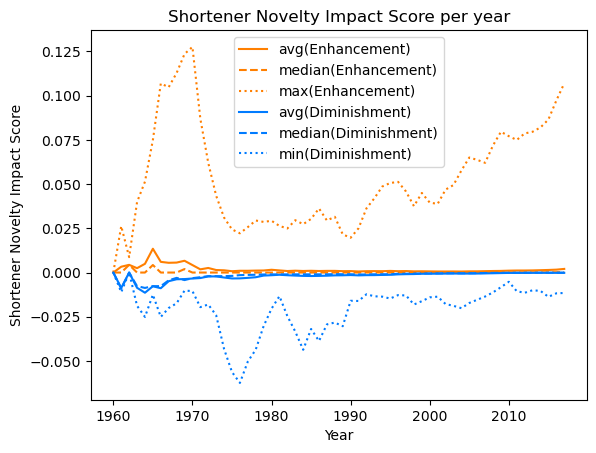

In [59]:
plotRange = (1960,2017)
dfYearlyDataPlot = dfYearlyData[(dfYearlyData["Year"]>=plotRange[0]) & (dfYearlyData["Year"]<=plotRange[1])]
plt.figure()
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyEnhancedAverage"],label="avg(Enhancement)", c="#ff7f00")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyEnhancedMedian"],label="median(Enhancement)", c="#ff7f00",linestyle="--")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyEnhancedMax"],label="max(Enhancement)", c="#ff7f00",linestyle=":")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyDiminishAverage"],label="avg(Diminishment)", c="#007bff")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyDiminishMedian"],label="median(Diminishment)", c="#007bff",linestyle="--")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyDiminishMin"],label="min(Diminishment)", c="#007bff",linestyle=":")
plt.xlabel("Year")
plt.ylabel("Shortener Novelty Impact Score")
plt.title("Shortener Novelty Impact Score per year")
plt.legend()
plt.show()




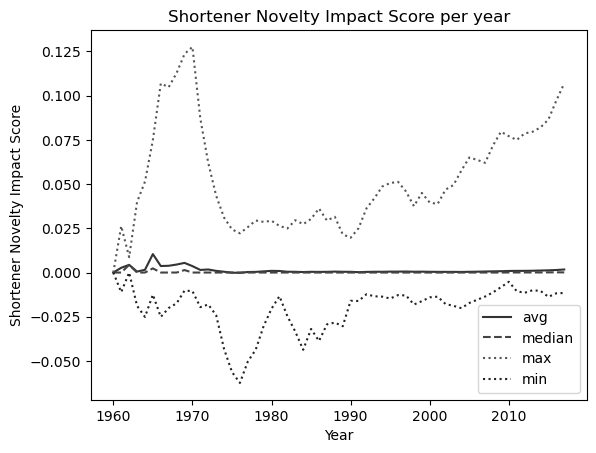

In [66]:
plotRange = (1960,2017)
dfYearlyDataPlot = dfYearlyData[(dfYearlyData["Year"]>=plotRange[0]) & (dfYearlyData["Year"]<=plotRange[1])]
plt.figure()
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyImpactAverage"],label="avg", c="#333333")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyImpactMedian"],label="median", c="#444444",linestyle="--")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyImpactMax"],label="max", c="#555555",linestyle=":")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyImpactMin"],label="min", c="#222222",linestyle=":")

plt.plot

plt.xlabel("Year")
plt.ylabel("Shortener Novelty Impact Score")
plt.title("Shortener Novelty Impact Score per year")
plt.legend()
plt.show()




In [ ]:
# plotRange = (1960,2017)
# dfYearlyDataPlot = dfYearlyData[(dfYearlyData["Year"]>=plotRange[0]) & (dfYearlyData["Year"]<=plotRange[1])]
# plt.figure()
# plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyFitEnhancedAverage"],label="avg(Enhancement)", c="#ff7f00")
# plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyFitEnhancedMedian"],label="median(Enhancement)", c="#ff7f00",linestyle="--")
# plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyFitEnhancedMax"],label="max(Enhancement)", c="#ff7f00",linestyle=":")
# plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyFitDiminishAverage"],label="avg(Diminishment)", c="#007bff")
# plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyFitDiminishMedian"],label="median(Diminishment)", c="#007bff",linestyle="--")
# plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["ShortenerNoveltyFitDiminishMin"],label="min(Diminishment)", c="#007bff",linestyle=":")
# plt.xlabel("Year")
# plt.ylabel("Shortener Novelty Impact Score (Fit)")
# plt.title("Shortener Novelty Impact Score per year")
# plt.legend()
# plt.show()




In [86]:
weightsSize = 4
yearRange = range(min(year2paperUIDs.keys()),max(year2paperUIDs.keys())+1)
progressBar = tqdm(total=len(dfPhilanthropy["PY"]))
strengthenerNoveltyByPaperID = {}
strengthenerNoveltyByYear = {}
for year in yearRange:
    edge2Weight = {}
    if(year-1 in year2paperUIDs):
        previousYearNetwork = scYearlyNetworks[year-1]
        # from the network get the weights of the edges
        for edge in previousYearNetwork.es:
            edgeIndices = (edge.source,edge.target)
            edgeIndices = (min(edgeIndices),max(edgeIndices))
            edge2Weight[edgeIndices] = edge["weight"]
    if(year in year2paperUIDs):
        papers = year2paperUIDs[year]
        for paperUID in papers:
            progressBar.update(1)
            if paperUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
                subjectCategories = [subjectCategory2Index[subjectCategory] for subjectCategory in subjectCategories]
                subjectCategories = list(set(subjectCategories))
                edges = list(combinations(subjectCategories,2))
                # make edges min(),max()
                edges = set([(min(edge),max(edge)) for edge in edges])
                edgesAndWeights.update(edges)
                edgeWeights = [edge2Weight[edge]+1 for edge in edges if edge in edge2Weight]

                strengthenerNovelty = list(np.histogram(edgeWeights,bins=range(2,weightsSize+3))[0])
                strengthenerNoveltyByPaperID[paperUID] = tuple(strengthenerNovelty)
        # year level
        edgeWeights = [edge2Weight[edge]+1 for edge in edgesAndWeights.keys() if edge in edge2Weight]
        strengthenerNovelty = list(np.histogram(edgeWeights,bins=range(2,weightsSize+3))[0])
        strengthenerNoveltyByYear[year] = tuple(strengthenerNovelty)
    else:
        strengthenerNoveltyByYear[year] = tuple([0]*weightsSize)
        # shortenerNoveltyByYear

# sort according to strengthenerNoveltyByPaperID via tuple sorting

strengthenerNoveltyByPaperIDSorted = [(k,v) for k, v in sorted(strengthenerNoveltyByPaperID.items(), key=lambda item: item[1],reverse=True)]
# create a rank for the strengthenerNoveltyByPaperID. If there is a tie, the two papers should have the same rank
strengthenerNoveltyByPaperIDRank = {}
currentRank = 0
currentRankCount = 0
previousStrengthenerNovelty = None
for entryName,strengthenerNovelty in strengthenerNoveltyByPaperIDSorted:
    currentRankCount+=1
    if(previousStrengthenerNovelty!=strengthenerNovelty):
        currentRank=currentRankCount
    strengthenerNoveltyByPaperIDRank[entryName] = currentRank
    previousStrengthenerNovelty = strengthenerNovelty

# strengthenerNoveltyByPaperIDRank = {entry[0]:index+1 for index,entry in enumerate(strengthenerNoveltyByPaperIDSorted)}
# paperUID2ReferencesSubjectCategories["WOS:A1996VL28900004"]

strengthenerNoveltyByYearIDSorted = [(k,v) for k, v in sorted(strengthenerNoveltyByYear.items(), key=lambda item: item[1],reverse=True)]
# create a rank for the strengthenerNoveltyByYear. If there is a tie, the two papers should have the same rank
strengthenerNoveltyByYearRank = {}
currentRank = 0
currentRankCount = 0
previousStrengthenerNovelty = None
for entryName,strengthenerNovelty in strengthenerNoveltyByYearIDSorted:
    currentRankCount+=1
    if(previousStrengthenerNovelty!=strengthenerNovelty):
        currentRank=currentRankCount
    strengthenerNoveltyByYearRank[entryName] = currentRank
    previousStrengthenerNovelty = strengthenerNovelty
strengtheneNoveltiyRankByYear = {entry[0]:index+1 for index,entry in enumerate(strengthenerNoveltyByYearIDSorted)}


  0%|          | 0/60685 [00:00<?, ?it/s]

In [87]:
print(list(strengthenerNoveltyByPaperIDRank.items())[10001])
print(strengthenerNoveltyByPaperIDSorted[10001])

('WOS:000072997700003', 9994)
('WOS:000072997700003', (0, 0, 2, 1))


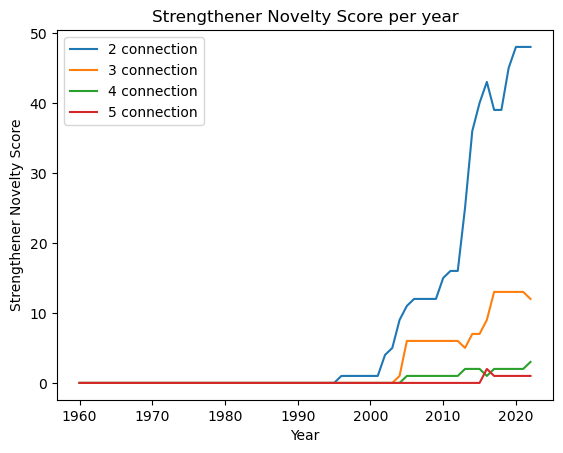

In [88]:
# Plot strengthenerNoveltyByYear X axis = year, Y axis = strengthenerNovelty
# each line correspond to a position of the tuple
# each line is a different color
plotRange = (1960,2022)
plt.figure()
for i in range(weightsSize):
    strengthenerYears = list(strengthenerNoveltyByYear.keys())
    strengthenerNovelties = [entry[i] for entry in strengthenerNoveltyByYear.values()]
    # limit to plot range
    strengthenerYears = [year for year in strengthenerYears if year>=plotRange[0] and year<=plotRange[1]]
    strengthenerNovelties = [strengthenerNovelties[index] for index,year in enumerate(strengthenerYears)]
    plt.plot(strengthenerYears,strengthenerNovelties,label=str(i+2)+" connection")
plt.xlabel("Year")
plt.ylabel("Strengthener Novelty Score")
plt.title("Strengthener Novelty Score per year")
plt.legend()
plt.show()



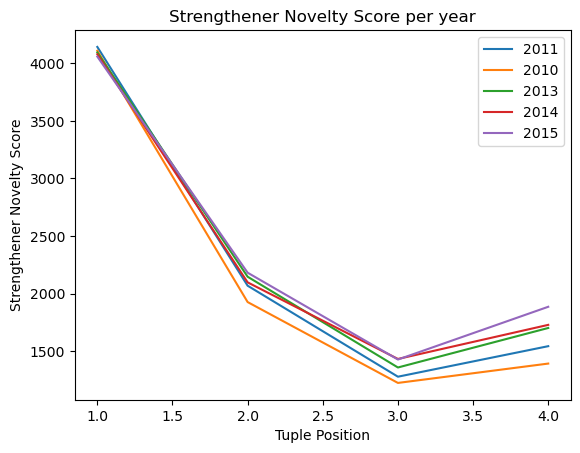

In [84]:
plt.figure()
for year, novelties in strengthenerNoveltyByYearIDSorted[1:6]:
    plt.plot(range(1,weightsSize+1),novelties,label=str(year))
plt.xlabel("Tuple Position")
plt.ylabel("Strengthener Novelty Score")
plt.title("Strengthener Novelty Score per year")
plt.legend()
plt.savefig("StrengthenerNoveltyScorePerYear.png",dpi=300,bbox_inches='tight')
plt.show()



In [89]:
interestingPaper = "WOS:A1996VL28900004"
# print the entire paper table without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dfReferencesFiltered[dfReferencesFiltered["UT"]==interestingPaper].T)



                                                91258
PT                                            Journal
AU  Alemi, F; Mosavel, M; Stephens, RC; Ghadiri, A...
BE                                                NaN
AF  Alemi, F; Mosavel, M; Stephens, RC; Ghadiri, A...
TI            Electronic self-help and support groups
SO                                       MEDICAL CARE
SE                                                NaN
LA                                            English
DT                                            Article
CT                                                NaN
CY                                                NaN
CL                                                NaN
SP                                                NaN
HO                                                NaN
DE  Internet; on-line services; computer applicati...
ID  COMPUTER-MEDIATED COMMUNICATION; ADDICTION SEV...
C1                 [] UNIV AKRON,DEPT SOCIOL,AKRON,OH
RP  [Alemi, F] CLEVELAND STA

In [77]:
dfPhilanthropy["StrengthenerNovelty"] = dfPhilanthropy["UT"].map(strengthenerNoveltyByPaperID).fillna(str(tuple([0]*weightsSize))).map(str)
dfPhilanthropy["StrengthenerNoveltyRank"] = dfPhilanthropy["UT"].map(strengthenerNoveltyByPaperIDRank)
dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)


In [78]:
dfYearlyData["StrengthenerNovelty"] = [strengthenerNoveltyByYear[year] if year in strengthenerNoveltyByYear else str(tuple([0]*weightsSize)) for year in dfYearlyData["Year"]]
dfYearlyData["StrengthenerNoveltyRank"] = [strengtheneNoveltiyRankByYear[year] if year in strengtheneNoveltiyRankByYear else 0 for year in dfYearlyData["Year"]]
dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)


In [90]:
window = 5
yearRange = range(min(year2paperUIDs.keys()),max(year2paperUIDs.keys())-window+1)
progressBar = tqdm(total=len(dfPhilanthropy["PY"]))
strengthenerNoveltyImpactByPaperID = {}
strengthenerNoveltyImpactByYear = {}
for year in yearRange:
    edge2Weight = {}
    if(year-1 in year2paperUIDs):
        previousYearNetwork = scYearlyNetworks[year-1]
        # from the network get the weights of the edges
        for edge in previousYearNetwork.es:
            edgeIndices = (edge.source,edge.target)
            edgeIndices = (min(edgeIndices),max(edgeIndices))
            edge2Weight[edgeIndices] = edge["weight"]
    changedSubjectCategories = set()
    if(year in year2paperUIDs):
        papers = year2paperUIDs[year]
        for paperUID in papers:
            progressBar.update(1)
            if paperUID in paperUID2ReferencesSubjectCategories:
                subjectCategories = paperUID2ReferencesSubjectCategories[paperUID]
                subjectCategories = [subjectCategory2Index[subjectCategory] for subjectCategory in subjectCategories]
                subjectCategories = list(set(subjectCategories))
                edges = list(combinations(subjectCategories,2))
                # make edges min(),max()
                edges = set([(min(edge),max(edge)) for edge in edges])
                edgesAndWeights.update(edges)
                allowedEdges=[edge for edge in edges if edge in edge2Weight and edge2Weight[edge]+1<=weightsSize+1]
                activatedSubjectCategories = set([subjectCategory for edge in allowedEdges for subjectCategory in edge])
                changedSubjectCategories.update(activatedSubjectCategories)
                
                strengthenerNoveltiyImpacts = []
                for subjectCategory in activatedSubjectCategories:
                    yearBeforeCitations = cumulativeCitationsReceivedSCYear[year-1][subjectCategory] if year-1 in cumulativeCitationsReceivedSCYear else 0
                    windowYearsAfterCitations = cumulativeCitationsReceivedSCYear[year+window][subjectCategory] if year+window in cumulativeCitationsReceivedSCYear else 0
                    strengthenerNoveltiyImpacts.append(windowYearsAfterCitations-yearBeforeCitations)
                strengthenerNoveltyImpactByPaperID[paperUID] = strengthenerNoveltiyImpacts
        # year level
        strengthenerNoveltiyImpacts = []
        for subjectCategory in changedSubjectCategories:
            yearBeforeCitations = cumulativeCitationsReceivedSCYear[year-1][subjectCategory] if year-1 in cumulativeCitationsReceivedSCYear else 0
            windowYearsAfterCitations = cumulativeCitationsReceivedSCYear[year+window][subjectCategory] if year+window in cumulativeCitationsReceivedSCYear else 0
            strengthenerNoveltiyImpacts.append(windowYearsAfterCitations-yearBeforeCitations)
        strengthenerNoveltyImpactByYear[year] = strengthenerNoveltiyImpacts
    else:
        strengthenerNoveltyImpactByYear[year] = []
        # shortenerNoveltyByYear

strengthenerNoveltyImpactByYearAverage = {year:np.average(strengthenerNoveltyImpactByYear[year]) if strengthenerNoveltyImpactByYear[year] else 0 for year in strengthenerNoveltyImpactByYear}
strengthenerNoveltyImpactByYearMedian = {year:np.median(strengthenerNoveltyImpactByYear[year]) if strengthenerNoveltyImpactByYear[year] else 0 for year in strengthenerNoveltyImpactByYear}
strengthenerNoveltyImpactByYearMax = {year:np.max(strengthenerNoveltyImpactByYear[year]) if strengthenerNoveltyImpactByYear[year] else 0 for year in strengthenerNoveltyImpactByYear}
strengthenerNoveltyImpactByYearMin = {year:np.min(strengthenerNoveltyImpactByYear[year]) if strengthenerNoveltyImpactByYear[year] else 0 for year in strengthenerNoveltyImpactByYear}

# scores by paper
strengthenerNoveltyImpactByPaperIDAverage = {paperUID:np.average(strengthenerNoveltyImpactByPaperID[paperUID]) if strengthenerNoveltyImpactByPaperID[paperUID] else 0 for paperUID in strengthenerNoveltyImpactByPaperID}
strengthenerNoveltyImpactByPaperIDMedian = {paperUID:np.median(strengthenerNoveltyImpactByPaperID[paperUID]) if strengthenerNoveltyImpactByPaperID[paperUID] else 0 for paperUID in strengthenerNoveltyImpactByPaperID}
strengthenerNoveltyImpactByPaperIDMax = {paperUID:np.max(strengthenerNoveltyImpactByPaperID[paperUID]) if strengthenerNoveltyImpactByPaperID[paperUID] else 0 for paperUID in strengthenerNoveltyImpactByPaperID}
strengthenerNoveltyImpactByPaperIDMin = {paperUID:np.min(strengthenerNoveltyImpactByPaperID[paperUID]) if strengthenerNoveltyImpactByPaperID[paperUID] else 0 for paperUID in strengthenerNoveltyImpactByPaperID}


  0%|          | 0/60685 [00:00<?, ?it/s]

In [91]:
dfPhilanthropy["StrengthenerNoveltyImpactAverage"] = dfPhilanthropy["UT"].map(strengthenerNoveltyImpactByPaperIDAverage).fillna(0)
dfPhilanthropy["StrengthenerNoveltyImpactMedian"] = dfPhilanthropy["UT"].map(strengthenerNoveltyImpactByPaperIDMedian).fillna(0)
dfPhilanthropy["StrengthenerNoveltyImpactMax"] = dfPhilanthropy["UT"].map(strengthenerNoveltyImpactByPaperIDMax).fillna(0)
dfPhilanthropy["StrengthenerNoveltyImpactMin"] = dfPhilanthropy["UT"].map(strengthenerNoveltyImpactByPaperIDMin).fillna(0)
dfPhilanthropy.to_csv(outputNoveltyArticleLevelTableFile,index=False)


In [92]:
dfYearlyData["StrengthenerNoveltyImpactAverage"] = [strengthenerNoveltyImpactByYearAverage[year] if year in strengthenerNoveltyImpactByYearAverage else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["StrengthenerNoveltyImpactMedian"] = [strengthenerNoveltyImpactByYearMedian[year] if year in strengthenerNoveltyImpactByYearMedian else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["StrengthenerNoveltyImpactMax"] = [strengthenerNoveltyImpactByYearMax[year] if year in strengthenerNoveltyImpactByYearMax else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData["StrengthenerNoveltyImpactMin"] = [strengthenerNoveltyImpactByYearMin[year] if year in strengthenerNoveltyImpactByYearMin else 0.0 for year in dfYearlyData["Year"]]
dfYearlyData.to_csv(outputNoveltyFieldLevelTableFile,index=False)




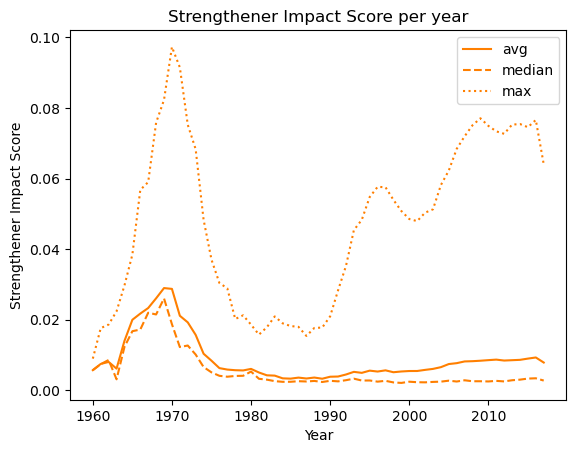

In [93]:
plotRange = (1960,2017)
dfYearlyDataPlot = dfYearlyData[(dfYearlyData["Year"]>=plotRange[0]) & (dfYearlyData["Year"]<=plotRange[1])]
plt.figure()
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["StrengthenerNoveltyImpactAverage"],label="avg", c="#ff7f00")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["StrengthenerNoveltyImpactMedian"],label="median", c="#ff7f00",linestyle="--")
plt.plot(dfYearlyDataPlot["Year"],dfYearlyDataPlot["StrengthenerNoveltyImpactMax"],label="max", c="#ff7f00",linestyle=":")
plt.xlabel("Year")
plt.ylabel("Strengthener Impact Score")
plt.title("Strengthener Impact Score per year")
plt.legend()
plt.show()




In [94]:

insideFieldIDs = set(dfPhilanthropy["UT"].values)
referencesPerYear = {}
referencesInsidePerYear = {}
for year,referencesData in zip(tqdm(dfPhilanthropy["PY"]),dfPhilanthropy["CI"]):
    if(referencesData==referencesData):
        references = referencesData.split("; ")
        references = [reference for reference in references if reference]
        if(year not in referencesPerYear):
            referencesPerYear[year] = []
        if(year not in referencesInsidePerYear):
            referencesInsidePerYear[year] = []
        for reference in references:
            if(reference in insideFieldIDs):
                referencesInsidePerYear[year].append(reference)
            referencesPerYear[year].append(reference)

# plot number of unique references per year inside and across all 


  0%|          | 0/60685 [00:00<?, ?it/s]

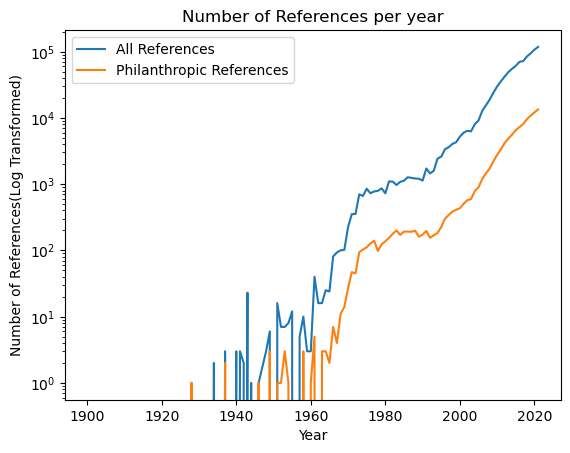

In [95]:
plotRange = (1900,2021)
plt.figure()
uniqueReferencesPerYear = {year:len(set(referencesPerYear[year])) for year in referencesPerYear if year in range(plotRange[0],plotRange[1]+1)}
uniqueReferencesInsidePerYear = {year:len(set(referencesInsidePerYear[year])) for year in referencesInsidePerYear if year in range(plotRange[0],plotRange[1]+1)}

plt.plot(list(uniqueReferencesPerYear.keys()),list(uniqueReferencesPerYear.values()),label="All References")
plt.plot(list(uniqueReferencesInsidePerYear.keys()),list(uniqueReferencesInsidePerYear.values()),label="Philanthropic References")
plt.xlabel("Year")
plt.ylabel("Number of References(Log Transformed)")
plt.yscale("log")
plt.title("Number of References per year")
plt.legend()
plt.savefig("NumberofUniqueReferencesPerYear.png",dpi=300,bbox_inches='tight')
plt.show()


In [96]:
philanthropyYears = dfPhilanthropy["PY"].to_list()
philanthropyYears = [int(year) for year in philanthropyYears]
philanthropyYears.sort()
philanthropyYears = np.array(philanthropyYears)
philanthropyYearsCount = np.unique(philanthropyYears,return_counts=True)
cummulativePhilanthropyYearsCount = np.cumsum(philanthropyYearsCount[1])
cummulativePhilanthropyCountPerYear = {year:count for year,count in zip(philanthropyYearsCount[0],cummulativePhilanthropyYearsCount)}


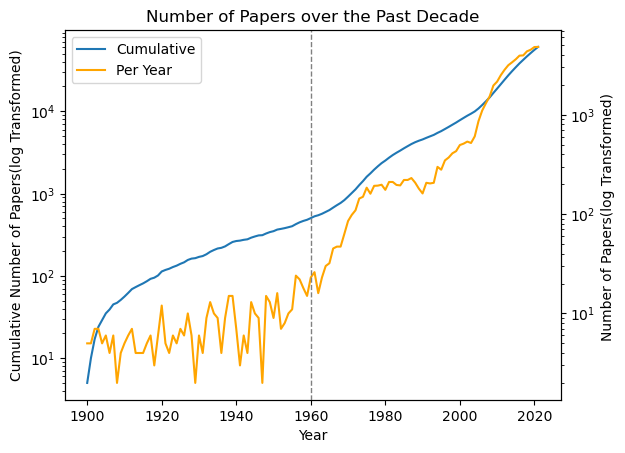

In [97]:
# Plot number of papers in df per year

year = philanthropyYearsCount[0]
paper = philanthropyYearsCount[1]
mask = (year >= 1900) & (year <= 2021)
filtered_year = year[mask]
filtered_paper = paper[mask]

plt.figure()
plt.plot(filtered_year,np.cumsum(filtered_paper),label="Cumulative")
plt.xlabel("Year")
plt.ylabel("Cumulative Number of Papers(log Transformed)")
plt.yscale("log")
# twin axis with regular number per year
ax2 = plt.twinx()
ax2.plot(filtered_year, filtered_paper,color="orange",label="Per Year")
ax2.set_ylabel("Number of Papers(log Transformed) ")
ax2.set_yscale("log")
plt.axvline(x=1960, color='grey', linestyle='--', linewidth=1)
plt.title("Number of Papers over the Past Decade")
line1, = plt.plot([], [], label='Cumulative')
line2, = plt.plot([], [], color='orange', label='Per Year')
plt.legend(handles=[line1, line2])
plt.savefig("Number_of_papers_per_year.png",dpi=300,bbox_inches='tight')
plt.show()



In [ ]:
philanthropyYearsCount

In [ ]:
# Count papers with no references
referenceCounts = dfPhilanthropy["CI"].str.split("; ").map(lambda x: [y for y in x if y] if (x==x) else []).map(lambda x: len(x) if (x==x and x) else 0)

In [ ]:
np.sum(referenceCounts==0)

In [ ]:
dfPhilanthropy["WC"]

In [ ]:
dfPhilanthropy["CI"].str.split("; ").iloc[1]